In [17]:
import nbimporter
from nbimporter import NotebookLoader

path = 'C:\\Users\\parva\\Desktop\\mldlnew\\training_MNIST.ipynb'
loader = NotebookLoader(path)
loader.load_module('training_MNIST')
from training_MNIST import *


In [18]:
# Importing all the libraries

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization
import os
import struct
import numpy as np
import training_MNIST

In [19]:
# Function to load MNIST data from ubyte files
def load_mnist(path, kind='train'):
    labels_path = os.path.join(path, f'{kind}-labels-idx1-ubyte')
    images_path = os.path.join(path, f'{kind}-images-idx3-ubyte')
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)
    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack('>IIII', imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 28, 28)
    return images, labels

# Load and preprocess the dataset
path = 'C:\\Users\\parva\\Desktop\\mldlnew\\MNIST'
x_train, y_train = load_mnist(path, kind='train')
x_test, y_test = load_mnist(path, kind='t10k')
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [20]:
# Build the DNN model
model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(256, activation='relu'),  # Increased to 256 neurons
    BatchNormalization(),  # Add batch normalization
    Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [21]:
import matplotlib.pyplot as plt

# Train the model and store the training history
history = model.fit(x_train, y_train, epochs=5, batch_size=32, validation_data=(x_test, y_test))

# Evaluate the model on the training data
_, training_accuracy = model.evaluate(x_train, y_train)
print(f'Training Accuracy: {training_accuracy}')

# Evaluate the model on the testing data
_, testing_accuracy = model.evaluate(x_test, y_test)
print(f'Testing Accuracy: {testing_accuracy}')

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.8993 - loss: 0.3343 - val_accuracy: 0.9677 - val_loss: 0.1080
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 36s 19ms/step - accuracy: 0.9680 - loss: 0.1062 - val_accuracy: 0.9726 - val_loss: 0.0870
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.9763 - loss: 0.0780 - val_accuracy: 0.9744 - val_loss: 0.0838
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9803 - loss: 0.0628 - val_accuracy: 0.9763 - val_loss: 0.0818
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.9853 - loss: 0.0480 - val_accuracy: 0.9741 - val_loss: 0.0839
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9892 - loss: 0.0346
Training Accuracy: 0.9892666935920715
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9688 - loss: 0.1033
Testing Accuracy: 0.9740999937057495


In [22]:
#-------------------- PGD Attack -------------------
epsilon = 0.06
alpha = 0.02
num_iter = 200

x_test_pgd = pgd_attack(model, x_test, y_test, epsilon, alpha, num_iter)
_, adv_testing_accuracy = model.evaluate(x_test_pgd, y_test)
print(f'Adversarial Testing Accuracy: {adv_testing_accuracy}')

y_pred_adv_subset = np.argmax(model.predict(x_test_pgd), axis=1)
success_rate_subset = np.mean(y_pred_adv_subset != np.argmax(y_test, axis=1))
print("Success rate of the PGD attack on the subset:", success_rate_subset)

#-------------------- BIM Attack  -------------------

epsilon = 0.06  
epsilon_iter = 0.05  
num_steps = 20  
x_test_adv = bim_attack(model, x_test, y_test, epsilon, epsilon_iter, num_steps)

_, adv_testing_accuracy = model.evaluate(x_test_adv, y_test)
print(f'Adversarial Testing Accuracy: {adv_testing_accuracy}')

y_pred_adv_subset = np.argmax(model.predict(x_test_adv), axis=1)
success_rate_subset = np.mean(y_pred_adv_subset != np.argmax(y_test, axis=1))
print("Success rate of the FGSM attack on the subset:", success_rate_subset)

#--------------------- C & W Attack -------------------

target_class = 0  # Target class for misclassification
x_adv = cw_attack(model, x_test, y_test, target_class)

# Evaluate the adversarially attacked model
_, adv_testing_accuracy = model.evaluate(x_adv, y_test)
print(f'Adversarial Testing Accuracy: {adv_testing_accuracy}')

# Evaluate the success rate of the attack on the subset
y_pred_adv_subset = np.argmax(model.predict(x_adv), axis=1)
success_rate_subset = np.mean(y_pred_adv_subset != np.argmax(y_test, axis=1))
print("Success rate of the FGSM attack on the subset:", success_rate_subset)

#--------------------- JSMA Attack  -------------------

# JSMA attack parameters
epsilon_jsma = 0.5
num_iterations_jsma = 150
theta_jsma = 0.5

# Generate adversarial examples for the full test data
x_adv_jsma_all = jsma_attack(model, x_test, y_test, epsilon=epsilon_jsma, num_iterations=num_iterations_jsma, theta=theta_jsma)

# Evaluate the model on the adversarial examples
adv_loss_jsma, adv_acc_jsma = model.evaluate(x_adv_jsma_all, y_test)

# Calculate the success rate of the attack
success_rate_jsma = (1 - adv_acc_jsma) * 100  # Misclassification rate
print("JSMA Attack - Success Rate:", success_rate_jsma, "%")


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2681 - loss: 3.5252
Adversarial Testing Accuracy: 0.3176000118255615
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Success rate of the PGD attack on the subset: 0.6824
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2830 - loss: 3.3543
Adversarial Testing Accuracy: 0.33329999446868896
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Success rate of the FGSM attack on the subset: 0.6667
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3197 - loss: 5.1331
Adversarial Testing Accuracy: 0.36980000138282776
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Success rate of the FGSM attack on the subset: 0.6302
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3290 - loss: 39.9307
JSMA Attack - Success Rate: 61.59999966621399 %


In [23]:
def feature_squeezing(x, bit_depth=1):
    factor = 256 // (2 ** bit_depth)
    return (x * 255 // factor * factor) / 255

# Apply feature squeezing on the input data
x_train_squeezed = feature_squeezing(x_train)
x_test_squeezed = feature_squeezing(x_test)

# Train model on squeezed data
model.fit(x_train_squeezed, y_train, epochs=5, batch_size=32, validation_data=(x_test_squeezed, y_test))

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9825 - loss: 0.0534 - val_accuracy: 0.9770 - val_loss: 0.0786
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9876 - loss: 0.0378 - val_accuracy: 0.9761 - val_loss: 0.0803
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9893 - loss: 0.0320 - val_accuracy: 0.9775 - val_loss: 0.0851
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9909 - loss: 0.0267 - val_accuracy: 0.9768 - val_loss: 0.0890
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.9911 - loss: 0.0259 - val_accuracy: 0.9777 - val_loss: 0.0846


In [26]:
#-------------------- PGD Attack -------------------
epsilon = 0.06
alpha = 0.02
num_iter = 200

x_test_pgd = pgd_attack(model, x_test, y_test, epsilon, alpha, num_iter)
_, adv_testing_accuracy = model.evaluate(x_test_pgd, y_test)
print(f'Adversarial Testing Accuracy: {adv_testing_accuracy}')

y_pred_adv_subset = np.argmax(model.predict(x_test_pgd), axis=1)
success_rate_PGD = (np.mean(y_pred_adv_subset != np.argmax(y_test, axis=1))) * 100
print("Success rate of the PGD attack on the subset:", success_rate_PGD)

#-------------------- BIM Attack  -------------------

epsilon = 0.06 
epsilon_iter = 0.05  
num_steps = 20  
x_test_adv = bim_attack(model, x_test, y_test, epsilon, epsilon_iter, num_steps)

_, adv_testing_accuracy = model.evaluate(x_test_adv, y_test)
print(f'Adversarial Testing Accuracy: {adv_testing_accuracy}')

y_pred_adv_subset = np.argmax(model.predict(x_test_adv), axis=1)
success_rate_BIM = (np.mean(y_pred_adv_subset != np.argmax(y_test, axis=1)))*100
print("Success rate of the BIM attack on the subset:", success_rate_BIM)

#--------------------- C & W Attack -------------------

target_class = 0  # Target class for misclassification
x_adv = cw_attack(model, x_test, y_test, target_class)

# Evaluate the adversarially attacked model
_, adv_testing_accuracy = model.evaluate(x_adv, y_test)
print(f'Adversarial Testing Accuracy: {adv_testing_accuracy}')

# Evaluate the success rate of the attack on the subset
y_pred_adv_subset = np.argmax(model.predict(x_adv), axis=1)
success_rate_CW = (np.mean(y_pred_adv_subset != np.argmax(y_test, axis=1))) *100
print("Success rate of the CW attack on the subset:", success_rate_CW)

#--------------------- JSMA Attack  -------------------

# JSMA attack parameters
epsilon_jsma = 0.5
num_iterations_jsma = 150
theta_jsma = 0.5

# Generate adversarial examples for the full test data
x_adv_jsma_all = jsma_attack(model, x_test, y_test, epsilon=epsilon_jsma, num_iterations=num_iterations_jsma, theta=theta_jsma)

# Evaluate the model on the adversarial examples
adv_loss_jsma, adv_acc_jsma = model.evaluate(x_adv_jsma_all, y_test)

# Calculate the success rate of the attack
success_rate_jsma = (1 - adv_acc_jsma) * 100  # Misclassification rate
print("JSMA Attack - Success Rate:", success_rate_jsma, "%")


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3368 - loss: 5.8399
Adversarial Testing Accuracy: 0.3752000033855438
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step
Success rate of the PGD attack on the subset: 62.480000000000004
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3627 - loss: 5.4376
Adversarial Testing Accuracy: 0.40130001306533813
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
Success rate of the BIM attack on the subset: 59.870000000000005
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8635 - loss: 2.6453
Adversarial Testing Accuracy: 0.8823999762535095
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
Success rate of the CW attack on the subset: 11.76
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8306 - loss: 27.3500
JSMA Attack - Success Rate: 14.520001411437988 %


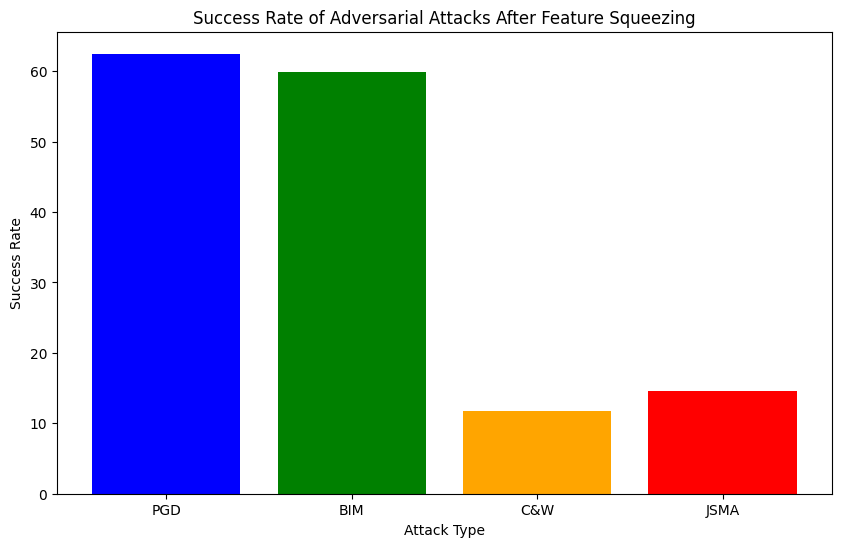

In [27]:
import matplotlib.pyplot as plt

# Success rates of the attacks
success_rates = [success_rate_PGD, success_rate_BIM, success_rate_CW, success_rate_jsma]

# Attack labels
attacks = ['PGD', 'BIM', 'C&W', 'JSMA']

# Plotting the bar graph
plt.figure(figsize=(10, 6))
plt.bar(attacks, success_rates, color=['blue', 'green', 'orange', 'red'])

# Adding labels and title
plt.xlabel('Attack Type')
plt.ylabel('Success Rate')
plt.title('Success Rate of Adversarial Attacks After Feature Squeezing')

# Displaying the plot
plt.show()
